In [31]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline
from skorch import NeuralNetClassifier # wrapping PyTorch models for use in scikit-learn
from sklearn.model_selection import GridSearchCV

In [32]:
# read in all the words
words = open('polish_names.txt', 'r').read().splitlines()
words


['aaron',
 'abbo',
 'abdiasz',
 'abdon',
 'abel',
 'abelard',
 'abercjusz',
 'abiasz',
 'abigail',
 'abraham',
 'absalon',
 'abundancja',
 'abundancjusz',
 'achacja',
 'achacjusz',
 'achacy',
 'achilles',
 'ada',
 'adalbert',
 'adalberta',
 'adalgunda',
 'adalruna',
 'adalryk',
 'adalwin',
 'adalwina',
 'adam',
 'adamina',
 'adamnan',
 'adaukt',
 'addar',
 'adela',
 'adelajda',
 'adelard',
 'adelina',
 'adelinda',
 'ademar',
 'adolf',
 'adolfa',
 'adolfina',
 'adrian',
 'adriana',
 'adrianna',
 'aelred',
 'afra',
 'afrodyta',
 'afrodyzja',
 'afrodyzjusz',
 'afrodyzy',
 'afrykan',
 'agapit',
 'agapita',
 'agapiusz',
 'agata',
 'agatangel',
 'agaton',
 'agatonik',
 'agatonika',
 'agenor',
 'aggeusz',
 'agis',
 'agnellus',
 'agnieszka',
 'agrykola',
 'agrypin',
 'agrypina',
 'agryppa',
 'ahmed',
 'aida',
 'aidan',
 'aisza',
 'aital',
 'ajaks',
 'akcjusz',
 'akwila',
 'akwilin',
 'akwilina',
 'alan',
 'alana',
 'alba',
 'alban',
 'albana',
 'albert',
 'alberta',
 'albertyna',
 'albin',
 'a

In [33]:
len(words)

2763

In [34]:
sum(len(x) for x in words)/len(words)

7.422366992399565

In [36]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
alphabet_len = len(chars) + 1
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'r', 18: 's', 19: 't', 20: 'u', 21: 'w', 22: 'y', 23: 'z', 24: 'ó', 25: 'ą', 26: 'ć', 27: 'ę', 28: 'ł', 29: 'ń', 30: 'ś', 31: 'ź', 32: 'ż', 0: '.'}


In [97]:
# build the dataset
block_size = 4 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      # print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([18589, 4]) torch.Size([18589])
torch.Size([2320, 4]) torch.Size([2320])
torch.Size([2362, 4]) torch.Size([2362])


In [109]:
emb_size = 7
# hidden_size = 100
# batch_size = 32

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((alphabet_len, emb_size), generator=g)
W1 = torch.randn((block_size * emb_size, 150), generator=g)
b1 = torch.randn(150, generator=g)
W2 = torch.randn((150, alphabet_len), generator=g)
b2 = torch.randn(alphabet_len, generator=g)
parameters = [C, W1, b1, W2, b2]    

In [110]:
for param in parameters:
            param.requires_grad_()

In [111]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [112]:
lri = []
lossi = []
stepi = []

In [113]:
C.shape

torch.Size([33, 7])

In [114]:
Xtr.shape

torch.Size([18589, 4])

In [140]:
for i in range(2000):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))
  
  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 10)
  h = torch.tanh(emb.view(-1, emb_size * block_size) @ W1 + b1) # (32, 200)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  #lr = lrs[i]
  # lr = 0.1 if i < 1000 else 0.01
  lr = 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

#print(loss.item())

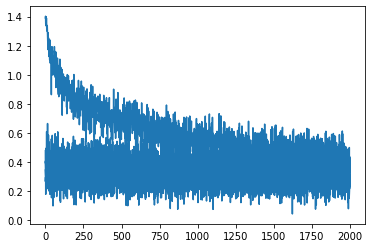

In [141]:
plt.plot(stepi, lossi)

In [142]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, emb_size * block_size) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(1.9635, grad_fn=<NllLossBackward0>)

In [143]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, emb_size * block_size) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.2594, grad_fn=<NllLossBackward0>)

In [149]:
names = []

# sample from the model
g = torch.Generator()# .manual_seed(2147483647 + 10)

for _ in range(50):
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    word = ''.join(itos[i] for i in out)
    if word not in words:
      names.append(''.join(itos[i] for i in out))
    # print(''.join(itos[i] for i in out))
names
      

['kinos.',
 'nomyd.',
 'gomir.',
 'dontra.',
 'porobodnak.',
 'dokus.',
 'munwery.',
 'juron.',
 'endy.',
 'telomin.',
 'żygorliel.',
 'hoyk.',
 'bous.',
 'aaulina.',
 'eumaalila.',
 'nufniem.',
 'skawanna.',
 'anata.',
 'relk.',
 'locha.',
 'witorobod.',
 'kkorum.',
 'zdziubąd.',
 'iłour.',
 'hela.',
 'elmfił.',
 'irm.',
 'świesław.',
 'astykarfor.',
 'lanimulia.',
 'damsjuwa.',
 'tenma.',
 'wirochia.',
 'łośanzik.',
 'egira.',
 'stroj.',
 'giow.',
 'aktolia.',
 'lala.',
 'gata.',
 'lumot.',
 'amir.',
 'ka.',
 'przjulisława.',
 'krakpor.',
 'boniniana.',
 'winiusz.',
 'lipontrud.',
 'mira.',
 'riena.']